In [57]:
from abc import ABC, abstractmethod
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import time


EPS = 1e-15

class LossFunction(ABC):

    @abstractmethod
    def fun(self, yhat, y):
        pass

    @abstractmethod
    def grad(self, yhat, y):
        pass

    def __call__(self, yhat, y):
        return self.fun(yhat, y)

class MSE(LossFunction):
    def fun(self, yhat, y):
        return np.sum((yhat - y)**2) / len(yhat)
    
    def grad(self, yhat, y):
        return 2 * (yhat-y)

class LogisticCrossEntropy(LossFunction):
    def fun(self, yhat , y):
        y_pred = np.clip(yhat, EPS, 1 - EPS)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def grad(self, yhat, y):
        y_pred = np.clip(yhat, EPS, 1 - EPS)
        return -(y / y_pred) + (1 - y) / (1 - y_pred)
    


class ActivationFunction(ABC):

    @abstractmethod
    def fun(self, x):
        pass

    @abstractmethod
    def grad(self, x):
        pass

    def __call__(self, x):
        return self.fun(x)
    

class Linear(ActivationFunction):
    def fun(self, x):
        return x

    def grad(self, x):
        return np.diagflat(np.ones(x.shape))
    

class Sigmoid(ActivationFunction):
    def fun(self, x):
        return 1 / (1 + np.exp(-x))
    
    def grad(self, x):
        return np.diagflat(self.fun(x) * (1 - self.fun(x)))
    
class Softmax(ActivationFunction):
    def fun(self, x):
        shifted_x = x - np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(shifted_x)
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def grad(self, x):
        s = self.fun(x).reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)
    
class GELU(ActivationFunction):
    def fun(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))
    
    def grad(self, x):
        tanh_part = np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3))
        return np.diagflat(0.5 * (1 + tanh_part) + 0.5 * x * (1 - tanh_part**2) * (np.sqrt(2/np.pi) + 0.134145 * x**2))


class ELU(ActivationFunction):
    def __init__(self, alpha = 1.0):
        self.alpha = alpha

    def fun(self, x):
        return np.where(x >= 0, x, self.alpha * (np.exp(x) - 1))
    
    def grad(self, x):
        return np.diagflat(np.where(x >= 0, 1, self.alpha * np.exp(x)))
    

class Layer:
    def __init__(self, neurons, input_shape, weights, bias, bias_active, activation: ActivationFunction):
        self.neurons = neurons
        self.input_shape = input_shape
        assert weights.shape == (input_shape[1], neurons)
        self.weights = weights
        assert bias.shape == (1, neurons)
        self.bias = bias if bias_active else np.zeros_like(bias)
        self.bias_active = bias_active
        self.activation = activation
        self.last_a = None

    def make_factory(neurons, input_shape, activation: ActivationFunction, factory, bias_active = True):
        return Layer(
            neurons = neurons,
            input_shape = input_shape,
            weights = factory((input_shape[1], neurons)),
            bias = factory((1, neurons)),
            activation = activation,
            bias_active=bias_active,
        )
    
    def make_zero(neurons, input_shape, activation, bias_active = True):
        return Layer.make_factory(neurons, input_shape, activation, np.zeros, bias_active)
    
    def make_random(neurons, input_shape, activation, bias_active = True):
        random_balanced = lambda shape: np.random.random(shape) - 0.5
        return Layer.make_factory(neurons, input_shape, activation, random_balanced, bias_active)
    
    def apply(self, inputs):
        intensities = inputs @ self.weights
        if self.bias_active:
            self.last_a = intensities + self.bias
        else:
            self.last_a = intensities
        return self.activation(self.last_a)
    
    def __str__(self):
        return f"LAYER(\nW:\n {repr(self.weights)} \nb:\n{repr(self.bias)})\n"

    def __repr__(self):
        return str(self)


class NN:
    def __init__(self, *layers, input_shape, use_gpu=False):
        self.input_shape = input_shape
        self.layers = [*layers]
        self.errors = None
        self.last_inputs = None
        self.use_gpu = use_gpu
    
    def get_last_shape(self):
        if self.layers:
            return self.layers[-1].weights.shape
        else:
            return self.input_shape

    def add_new_zero_layer(self, neurons, activation:Optional[ActivationFunction] = None, bias_active=True):
        activation = activation or Sigmoid()
        layer = Layer.make_zero(
            neurons,
            self.get_last_shape(),
            activation,
            bias_active,
        )
        self.layers.append(layer)
        return layer
    
    def add_new_random_layer(self, neurons, activation: Optional[ActivationFunction] = None, bias_active=True):
        activation = activation or Sigmoid()
        layer = Layer.make_random(
            neurons,
            self.get_last_shape(),
            activation,
            bias_active,
        )
        self.layers.append(layer)
        return layer
    
    def apply(self, inputs):
        self.last_inputs = inputs
        x = inputs
        for layer in self.layers:
            x = layer.apply(x)
        return x

    def calculate_errors(self, yhat, y, loss):
        errors = [None] * len(self.layers)
        errors[-1] = loss.grad(yhat, y)
        for i in range(len(errors)-2, -1, -1):
            uhm = errors[i+1] @ np.transpose(self.layers[i+1].weights)
            grad_fun = self.layers[i].activation.grad
            errors[i] = uhm @ grad_fun(self.layers[i].last_a)
        return errors       
    
    def calculate_grads(self, errors):
        grad = [None] * len(self.layers)
        grad_b = [None] * len(self.layers)
        
        for k in range(len(errors)):
            if k == 0:
                f_a = self.layers[0].activation(self.last_inputs)
            else:
                cur_layer = self.layers[k-1]
                f_a = cur_layer.activation(cur_layer.last_a)
            
            grad[k] = np.vstack(np.transpose(f_a)) @ errors[k]
            grad_b[k] = errors[k] 
        return grad, grad_b

    def get_zero_grads(self):
        grad = [None] * len(self.layers)
        grad_b = [None] * len(self.layers)
        for i, layer in enumerate(self.layers):
            grad[i] = np.zeros(layer.weights.shape)
            grad_b[i] = np.zeros(layer.bias.shape)
        return grad, grad_b

    def backpropagate(self, yhat, y, loss):
        errors = self.calculate_errors(yhat, y, loss)
        return self.calculate_grads(errors)
    
    def log_data(self, weights_path: str, errors_path: str, save_format: str = 'pickle'):
        weight_data = [(layer.weights, layer.bias) for layer in self.layers]
        if save_format == 'pickle':
            with open(weights_path, 'wb') as f:
                pickle.dump(weight_data, f)
        elif save_format == 'txt':
            with open(weights_path, 'w') as f:
                for w, b in weight_data:
                    f.write(f"Weights:\n{w}\nBiases:\n{b}\n")

    def log_errors(self, errors, path: str, save_format: str = 'pickle'):
        if save_format == 'pickle':
            with open(path, 'wb') as f:
                pickle.dump(errors, f)
        elif save_format == 'txt':
            with open(path, 'w') as f:
                for err in errors:
                    f.write(f"Errors:\n{err}\n")

    def gradient_descent(self, x, y, loss: LossFunction, rate=1e-3, weights_path=None, errors_path=None, log_format='pickle'):
        sumg, sumgb = self.get_zero_grads()
        for i, x_i in enumerate(x):
            yhat = self.apply(x_i.reshape(1, -1))
            g, gb = self.backpropagate(yhat, y[i], loss)
            for i in range(len(self.layers)):
                sumg[i] -= rate * g[i]
                sumgb[i] -= rate * gb[i]

        for i in range(len(self.layers)):
            self.layers[i].weights += sumg[i] / x.shape[0]
            self.layers[i].bias += sumgb[i] / x.shape[0]

        if weights_path and errors_path:
            self.log_data(weights_path, errors_path, log_format)

    def batch_descent(self, x, y, loss: LossFunction, rate=1e-3, batch_size=None, weights_path=None, errors_path=None, log_format='pickle'):
        batch_size = batch_size or x.shape[0]//10
        indexes = np.random.randint(x.shape[0], size=(batch_size, 1))
        x_chosen = x[indexes]
        y_chosen = y[indexes]
        self.gradient_descent(x_chosen, y_chosen, loss, rate=rate, weights_path=weights_path, errors_path=errors_path, log_format=log_format)

    def stochastic_descent(self, x, y, loss: LossFunction, rate=1e-3, weights_path=None, errors_path=None, log_format='pickle'):
        index = np.random.randint(x.shape[0])
        x_i = x[index]
        y_i = y[index]
        yhat_i = self.apply(x_i.reshape(1, -1))
        g, gb = self.backpropagate(yhat_i, y_i, loss)
        for i in range(len(self.layers)):
            self.layers[i].weights -= rate * g[i]
            self.layers[i].bias -= rate * gb[i]

        if weights_path and errors_path:
            self.log_data(weights_path, errors_path, log_format)


    def draw(self, show_weights=False):

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('off')
        layer_sizes = [self.input_shape[1]] + [layer.neurons for layer in self.layers]

        x_positions = np.linspace(0, len(layer_sizes) - 1, len(layer_sizes))

        y_positions = [
            np.linspace(-layer_size / 2, layer_size / 2, layer_size) if layer_size > 1 else [0]
            for layer_size in layer_sizes
        ]

        for layer_index, (layer_size, y_pos) in enumerate(zip(layer_sizes, y_positions)):
            for neuron_index in range(layer_size):
                ax.plot(x_positions[layer_index], y_pos[neuron_index], 'o', markersize=12, color='skyblue')

        for i in range(len(self.layers)):
            layer1_y_pos = y_positions[i]
            layer2_y_pos = y_positions[i + 1]
            weights = self.layers[i].weights

            for j, y1 in enumerate(layer1_y_pos):
                for k, y2 in enumerate(layer2_y_pos):
                    ax.plot([x_positions[i], x_positions[i + 1]], [y1, y2], 'k-', linewidth=0.5)

                    if show_weights:
                        weight = weights[j, k]
                        mid_x = (x_positions[i] + x_positions[i + 1]) / 2
                        mid_y = (y1 + y2) / 2
                        ax.text(mid_x, mid_y, f'{weight:.2f}', ha='center', va='center', fontsize=8, color='purple')

        ax.text(x_positions[0], max(y_positions[0]) + 1.5, 'Input Layer', ha='center', fontsize=12, color='black')
        ax.text(x_positions[-1], max(y_positions[-1]) + 1.5, 'Output Layer', ha='center', fontsize=12, color='black')

        plt.show()

    def reset_weights_and_biases(self):
        for layer in self.layers:
            layer.weights = np.random.random(layer.weights.shape) - 0.5
            layer.bias = np.random.random(layer.bias.shape) - 0.5

In [207]:
from textwrap import indent
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def MSE(x, y):
    return np.sum((x - y)**2) / len(x)

def CCE(yhat, y):
    y_pos = np.argmax(y != 0.0, axis=1)
    return -np.mean(np.log(yhat[y_pos]))

def macro_f1(yhat, y, ohe_size=2):
    yhat_ohe = ohe(yhat, ohe_size=ohe_size)
    y_ohe = ohe(y, ohe_size=ohe_size)
    contingency_matrix = yhat_ohe.T @ y_ohe
    assert contingency_matrix.shape == (ohe_size, ohe_size), "incorrect shape from OHE"
    f1 = []
    for i in range(contingency_matrix.shape[0]):
        correct   = contingency_matrix[i,i]
        precision = correct / np.sum(contingency_matrix[i, :])
        recall    = correct / np.sum(contingency_matrix[:, i])
        f1_score  = 2*(precision * recall) / (precision + recall)
        f1.append(f1_score)
    return sum(f1)/len(f1)

def f1_fromohe_factory(ohe_size):
    def f1_macro_ohe(yhat, y):
        return macro_f1(rohe(yhat), rohe(y), ohe_size=ohe_size)
    return f1_macro_ohe

def ohe_one(which, length):
    out = np.zeros(shape=(length))
    out[which] = 1.0
    return out
    
def ohe(y, ohe_size=None):
    if ohe_size:
        length = ohe_size
    else:
        length = len(np.unique(y))
    return np.array([ohe_one(el, length) for el in y])

def rohe(y):
    return np.argmax(y, axis=1)

class Loss:
    def __init__(self) -> None:
        pass

    def f(self, yhat, y):
        pass
    
    def df(self, x, y):
        pass

class MSELoss(Loss):
    def __init__(self) -> None:
        super().__init__()
    
    def f(self, yhat, y):
        return np.sum((yhat - y)**2) / len(yhat)
    
    def df(self, yhat, y):
        return (yhat - y)

class CCESoftMaxLoss(Loss):
    def __init__(self) -> None:
        super().__init__()

    def f(self, yhat, y):
        y_pos = np.argmax(y != 0.0)
        return - np.log(yhat[y_pos])

    def df(self, yhat, y):
        return yhat - y

class Activation:
    def __init__(self):
        pass

    def f(self, x):
        pass

    def df(self, x):
        pass

class SigmoidActivation(Activation):
    def __init__(self):
        pass

    def f(self, x):
        return 1 / (1 + np.exp(-x))

    def df(self, x):
        sigx = self.f(x)
        return sigx * (1 - sigx)

class LinearActivation(Activation):
    def __init__(self):
        pass

    def f(self, x):
        return x

    def df(self, x):
        return 1

class SoftmaxActivation(Activation):
    def __init__(self):
        pass

    def f(self, x):
        offset = np.max(x)
        safe_x = x - offset
        exp_x  = np.exp(safe_x)
        sum_exp_x = np.sum(exp_x, axis=1).reshape((x.shape[0], 1))

        return exp_x / sum_exp_x

    def df(self, x):
        raise ValueError("Softmax shouldn't be used with a derivative")

class TanhActivation(Activation):
    def __init__(self):
        pass

    def f(self, x):
        return np.tanh(x)
    
    def df(self, x):
        return 1 - np.tanh(x) ** 2

class ReluActivation(Activation):
    def __init__(self):
        pass

    def f(self, x):
        return np.maximum(x, 0.0)

    def df(self, x):
        return np.where(x >= 0.0, 1.0, 0.0)

class ActivationStrategy:
    def __init__(self):
        pass

    def execute(self, architecture):
        raise NotImplementedError

class SigmoidLinearActivationStrategy(ActivationStrategy):
    def __init__(self):
        self.sigmoid = SigmoidActivation()
        self.linear = LinearActivation()

    def execute(self, architecture: (int)):
        length = len(architecture)
        return [self.sigmoid] * (length - 2) + [self.linear]

class SigmoidSoftmaxActivationStrategy(ActivationStrategy):
    def __init__(self):
        self.sigmoid = SigmoidActivation()
        self.softmax = SoftmaxActivation()
    
    def execute(self, architecture):
        length = len(architecture)
        return [self.sigmoid] * (length - 2) + [self.softmax]

class ActivationStrategyFactory:
    def __init__(self):
        pass
    
    def get(self):
        raise NotImplementedError

class BodyEndActivationStrategyFactory(ActivationStrategyFactory):
    def __init__(self, body_activation:Activation, end_activation:Activation):
        class ConcreteActivationStrategy(ActivationStrategy):
            def __init__(self):
                self.body = body_activation
                self.end = end_activation
            def execute(self, architecture):
                length = len(architecture)
                return [self.body] * (length - 2) + [self.end]
        self.strategy = ConcreteActivationStrategy()
    
    def get(self):
        return self.strategy

class Initializer:
    def __init__(self):
        pass
    def get(self, shape):
        raise NotImplementedError
    def __call__(self, shape):
        return self.get(shape)

class ZeroInitializer(Initializer):
    def get(self, shape):
        return np.zeros(shape)

class UniformInitializer(Initializer):
    def __init__(self, lower=-1, higher=1):
        self.lower = lower
        self.higher = higher

    def get(self, shape):
        return np.random.random(shape) * (self.higher - self.lower) + self.lower

class LayerFactory:
    def __init__(self, initializer: Initializer):
        self.initializer = initializer

    def get(self, layer_shape, activation):
        inbound_shape, neurons = layer_shape
        return Layer(
            weights = self.initializer((inbound_shape, neurons)),
            bias = self.initializer((1, neurons)),
            activation = activation
        )

class Layer:   
    def __init__(self, weights: np.array, bias: np.array, activation: Activation):
        self.weights = weights
        self.bias = bias
        self.activation = activation
    
    def feedforward(self, inputs):
        intensities = inputs.dot(self.weights)
        inbound = intensities + self.bias
        outbound = self.activation.f(inbound)
        return inbound, outbound
    
    def apply(self, inputs):
        intensities = inputs @ self.weights
        return self.activation.f(intensities + self.bias)
    
    def __str__(self):
        from textwrap import indent 
        return "Layer(\n{}\n)".format(
            indent(f"Weights:\n{repr(self.weights)}\nBias:\n{repr(self.bias)}", "  ")
        )

from typing import List

class NN:
    def __init__(self, layers: List[Layer], loss: Loss):
        self.layers = layers
        self.loss = loss
        
    def apply(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer.apply(x)
        return x

    def feedforward(self, inputs):
        x = inputs
        self.last_input = inputs
        inbound_list = []
        outbound_list = []
        for layer in self.layers:
            inbound, x = layer.feedforward(x)
            inbound_list.append(inbound)
            outbound_list.append(x)
        return inbound_list, outbound_list
    
    def calculate_errors(self, y, inbound, outbound):
        errors = [None] * len(self.layers)
        yhat = outbound[-1]
        
        errors[-1] = self.loss.df(yhat, y)
        for i in range(len(errors)-2, -1, -1):
            uhm = errors[i+1] @ self.layers[i+1].weights.T
            errors[i] = self.layers[i].activation.df(inbound[i]) * uhm
        return errors
    
    def calculate_grad(self, errors, inbound, outbound):
        batch_size = errors[0].shape[0]
        # todo: cleanup
        grad_b = [
            error.T.dot(np.ones((batch_size,1))).T/float(batch_size) 
            for error in errors
        ]
        
        inputs = [self.last_input] + outbound
        
        grad = [
            error.T.dot(inputs[i]).T/float(batch_size) 
            for i, error in enumerate(errors)
        ]
        return grad, grad_b
    
    def backpropagate(self, x, y):
        inbound, outbound = self.feedforward(x)
        errors = self.calculate_errors(y, inbound, outbound)
        grad, grad_b = self.calculate_grad(errors, inbound, outbound)
        return grad, grad_b
    
    def apply_grad(self, sumg, sumgb):
        for i in range(len(self.layers)):
            self.layers[i].weights += sumg[i]
            self.layers[i].bias += sumgb[i]
    
    def get_zero_grads(self):
        g0 = [g.weights * 0.0 for g in self.layers]
        gb0 = [gb.bias * 0.0 for gb in self.layers]
        return g0, gb0

    def __str__(self):
        from textwrap import indent 
        return "Layers(\n{}\n)".format(
            indent(
                "\n".join(
                    str(i) + ": " + str(l)
                    for i, l in enumerate(self.layers)
                ),
                "  "
            )
        )

class NNFactory:
    def __init__(self, activation_strategy: ActivationStrategy, layer_factory: LayerFactory, loss: Loss):
        self.activation_strategy = activation_strategy
        self.layer_factory = layer_factory
        self.loss = loss

    def get(self, architecture):
        layer_shapes = list(zip(architecture[:-1], architecture[1:]))
        activation_types = self.activation_strategy.execute(architecture)

        layers = [
            self.layer_factory.get(
                layer_shape,
                activation
            ) for layer_shape, activation 
            in zip(layer_shapes, activation_types)
        ]

        return NN(layers, self.loss)

class ProgressTracker:
    def __init__(self, interval):
        self.interval = interval
        self.moments = []
        self.records = []

    def start(self, yhat, y):
        print(f"F1 score {macro_f1(rohe(yhat), rohe(y))}")

    def update(self, yhat, y):
        print(f"F1 score {macro_f1(rohe(yhat), rohe(y))}")

class DummyProgressTracker(ProgressTracker):
    def __init__(self):
        super().__init__(float("inf"))

    def start(self, yhat, y):
        pass

    def update(self, yhat, y):
        pass

class EpochLossTracker(ProgressTracker):
    def __init__(self, interval, metric):
        super().__init__(interval)
        self.metric = metric
    
    def start(self, yhat, y):
        self.moments.append(0)
        self.records.append(self.metric(yhat, y))

    def update(self, yhat, y):
        self.moments.append(self.moments[-1] + self.interval)
        self.records.append(self.metric(yhat, y))

class TimeLossTracker(ProgressTracker):  
    def __init__(self, interval, metric):
        super().__init__(interval)
        self.metric = metric
        self.start_time = None
    
    def start(self, yhat, y):
        self.start_time = time.time_ns()
        self.moments.append(0)
        self.records.append(self.metric(yhat, y))
    
    def update(self, yhat, y):
        loss = self.metric(yhat, y)
        moment = (time.time_ns() - self.start_time) * 1e-9
        print(f"\r{self.metric.__name__} at {moment:.2f}s: {loss}".ljust(30), end='')
        self.moments.append(moment)
        self.records.append(loss)

class Evaluator:
    def evaluate(self, nn, x, y):
        pass

    def plot_results(self, nn, x, y):
        pass

class SingleRegressionEvaluator(Evaluator):
    def evaluate(self, nn, x, y):
        return MSE(nn.apply(x), y)

    def plot_results(self, nn, x, y, title, dataset):
        print()
        plt.scatter(
            x, nn.apply(x)
        )
        plt.scatter(
            x, y
        )
        plt.legend(["yhat", "y"])
        plt.title(title + ", " + dataset)

class MultiClassificationEvaluator(Evaluator):  
    def __init__(self) -> None:
        self.miss_color = "#ff0000"
        self.correct_color = "#aaaaaa"
    
    def evaluate(self, nn, x, y):
        return macro_f1(rohe(nn.apply(x)), rohe(y))

    def plot_results(self, nn, x, y, title, dataset):
        print(f"{title}, {dataset} F-measure (macro): {self.evaluate(nn, x, y)}")
        yhat_org = rohe(nn.apply(x))
        y_org = rohe(y)
        fig, axes = plt.subplots(1, 3)
        xi, yi = fig.get_size_inches()
        fig.set_size_inches(xi*3, yi)
        axes[0].scatter(x[:, 0], x[:, 1], c=yhat_org, cmap="viridis")
        axes[0].set_title(f"{title}, {dataset}, Predict")
        axes[1].scatter(x[:, 0], x[:, 1], c=y_org, cmap="viridis")
        axes[1].set_title(f"{title}, {dataset}, Actual")
        correct = y_org.flatten()==yhat_org.flatten()
        coloration = [self.correct_color if el else self.miss_color for el in correct]
        axes[2].scatter(x[:, 0], x[:, 1], c=coloration)
        axes[2].set_title(f"{title}, {dataset}, Misclassified")

class Trainer:
    def __init__(
            self,
            nn: NN,
            x: np.array, 
            y: np.array, 
            x_test=None, 
            y_test=None,
            dataset_name="", 
            tracker: ProgressTracker=None, 
            evaluator: Evaluator=Evaluator()
        ):
        self.nn = nn
        self.x = x
        self.y = y     
        self.x_test = x_test
        self.y_test = y_test
        self.dataset_name = dataset_name
        self.tracker = tracker if tracker else DummyProgressTracker()
        self.evaluator = evaluator

    def apply_rate(self, grads, rate):
        return [- g * rate for g in grads]

    def batch_descent(self, x, y, rate):
        sumg, sumgb = self.nn.backpropagate(x, y)
        self.nn.apply_grad(
            self.apply_rate(sumg,  rate),
            self.apply_rate(sumgb, rate),
        )
    
    def gradient_descent(self, rate):
        self.batch_descent(self.x, self.y, rate)

    def train_generic(self, method, max_epoch):
        self.tracker.start(self.nn.apply(self.x), self.y)
        for i in range(max_epoch):
            method()
            if i % self.tracker.interval == 0:
                self.tracker.update(self.nn.apply(self.x), self.y)

    def train_gradient(self, max_epoch, rate=1e-3):
        def gradient():
            self.gradient_descent(rate)
        self.train_generic(gradient, max_epoch)

    def train_random_batch(self, max_epoch, batch_size, rate=1e-3):
        def random_batch():
            indexes = np.random.randint(self.x.shape[0], size=batch_size)
            x_chosen = self.x[indexes]
            y_chosen = self.y[indexes]
            self.batch_descent(x_chosen, y_chosen, rate)
        self.train_generic(random_batch, max_epoch)

    def momentum_method_batch(self, max_epoch, batch_size=32, momentum_rate=0.9, rate=1e-3):
        m_g, m_gb = self.nn.get_zero_grads()
        def momentum_batch():
            nonlocal m_g, m_gb
            indexes = np.random.randint(self.x.shape[0], size=batch_size)
            x_chosen = self.x[indexes]
            y_chosen = self.y[indexes]
            g, gb = self.nn.backpropagate(x_chosen, y_chosen)
            m_g  = [mgi  * momentum_rate - rate * gi  for mgi, gi   in zip(m_g, g)]
            m_gb = [mgbi * momentum_rate - rate * gbi for mgbi, gbi in zip(m_gb, gb)]
            self.nn.apply_grad(m_g, m_gb)
        self.train_generic(momentum_batch, max_epoch)
    
    def rmsprop_method(self, max_epoch, slowdown_rate=0.9, rate=1e-3):
        eps = 0.0001
        slow_g , slow_gb = self.nn.get_zero_grads()
        def rmsprop():
            nonlocal slow_g , slow_gb
            g, gb = self.nn.backpropagate(self.x, self.y)
            
            slow_g = [slowgi * slowdown_rate + (1-slowdown_rate)*gi*gi
                for slowgi, gi in zip(slow_g, g)]

            slow_gb = [slowgbi * slowdown_rate + (1-slowdown_rate)*gbi*gbi
                for slowgbi, gbi in zip(slow_gb, gb)]

            final_g = [- rate * gi / np.sqrt(slowgi + eps) 
                for slowgi, gi in zip(slow_g, g)]

            final_gb = [- rate * gbi / np.sqrt(slowgbi + eps) 
                for slowgbi, gbi in zip(slow_gb, gb)]

            self.nn.apply_grad(final_g, final_gb)
        self.train_generic(rmsprop, max_epoch)

    def get_xy(self, dataset):
        if dataset == "train":
            return self.x, self.y
        elif dataset == "test":
            return self.x_test, self.y_test
        else:
            raise ValueError

    def evaluate(self, dataset="train"):
        x, y = self.get_xy(dataset)
        return self.evaluator.evaluate(self.nn, x, y)

    def plot_results(self, title=None, dataset="train"):
        title = title if title else self.dataset_name
        x, y = self.get_xy(dataset)
        self.evaluator.plot_results(self.nn, x, y, title, dataset)
        
    
    def plot_progress(self):
        print(self.evaluate("train"))
        plt.plot(
            self.tracker.moments,
            self.tracker.records
        )

In [19]:
def data_loader(path_train, path_test):
    df_train = pd.read_csv(path_train)
    df_test = pd.read_csv(path_test)
    return (df_train.iloc[:,0]).reshape(len(df_train), 1), (df_train.iloc[:,1]).reshape(len(df_train), 1), (df_test.iloc[:,0]).reshape(len(df_test), 1), (df_test.iloc[:,1]).reshape(len(df_test), 1)


In [32]:
#Test 1 - predykcja 
#Dla 100 epok uczenia się
df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))


In [33]:
nn1 = NN(input_shape=(0,1))
h11 = nn1.add_new_random_layer(10, GELU())
#h21 = nn1.add_new_random_layer(10, GELU())
#h31 = nn1.add_new_random_layer(10, GELU())
#h41 = nn1.add_new_random_layer(10, GELU())
ol1 = nn1.add_new_random_layer(1, activation=Linear())

In [36]:
np.random.seed(1337)
errors = []
errors_test = []
x = x_train
y = y_train
LR = 0.0001
loss = MSE()
for i in range(10000):
    nn1.stochastic_descent(x, y, rate=LR, loss=loss)
    errors.append(MSE()(nn1.apply(x), y))
    errors_test.append(MSE()(nn1.apply(x_test), y_test))

MSE (train): 0.34399


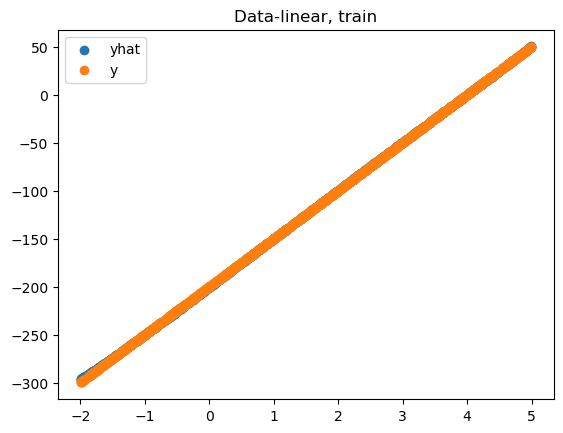

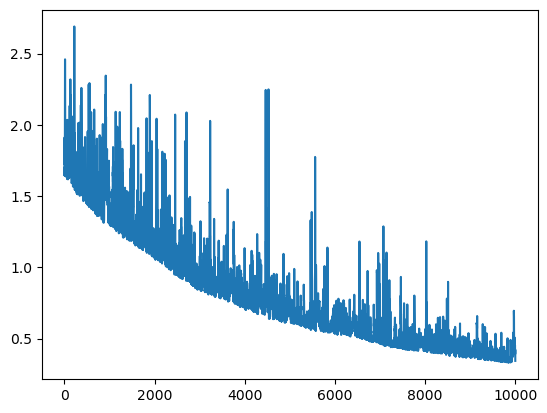

In [39]:
print(f"MSE (train): {loss(nn1.apply(x), y):.5}")

plt.scatter(x, nn1.apply(x))
plt.scatter(x,y)
plt.title("Data-linear, train")
plt.legend(["yhat", "y"])
plt.show()

plt.plot(range(len(errors)), errors)
plt.plot(range(len(errors_test)), errors_test)
plt.show()

In [40]:
nn2 = NN(input_shape=(0,1))
h12 = nn2.add_new_random_layer(10, GELU())
h22 = nn2.add_new_random_layer(10, GELU())
#h31 = nn1.add_new_random_layer(10, GELU())
#h41 = nn1.add_new_random_layer(10, GELU())
ol2 = nn2.add_new_random_layer(1, activation=Linear())

In [43]:
np.random.seed(1337)
errors_2 = []
errors_test_2 = []
x = x_train
y = y_train
LR = 0.0001
loss = MSE()
for i in range(10000):
    nn2.stochastic_descent(x, y, rate=LR, loss=loss)
    errors.append(MSE()(nn1.apply(x), y))
    errors_test.append(MSE()(nn1.apply(x_test), y_test))

MSE (train): 2.5493


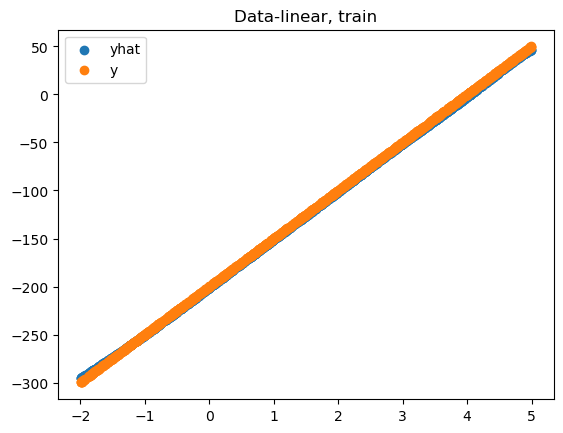

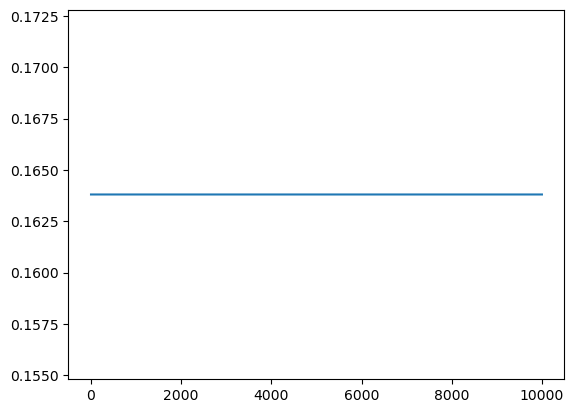

In [44]:
print(f"MSE (train): {loss(nn2.apply(x), y):.5}")

plt.scatter(x, nn2.apply(x))
plt.scatter(x,y)
plt.title("Data-linear, train")
plt.legend(["yhat", "y"])
plt.show()

plt.plot(range(len(errors)), errors)
#plt.plot(range(len(errors_test)), errors_test)
plt.show()

In [16]:
nn1 = NN(input_shape=(0,1))
h11 = nn1.add_new_random_layer(5)
h21 = nn1.add_new_random_layer(5)
h22 = nn1.add_new_random_layer(5)
ol1 = nn1.add_new_random_layer(1, activation=Linear)

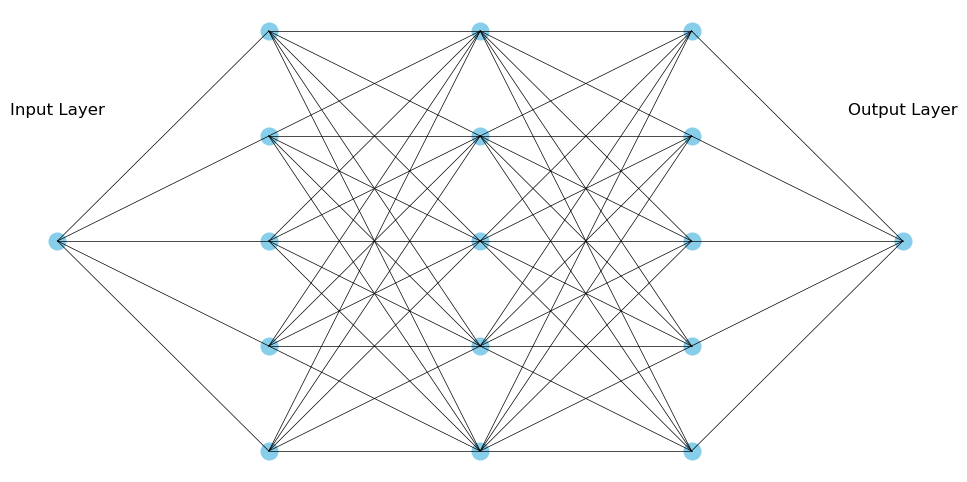

In [17]:
nn1.draw()

In [58]:
nn3 = NN(input_shape=(0,1))
h13 = nn3.add_new_random_layer(10, GELU())
h23 = nn3.add_new_random_layer(10, GELU())
ol3 = nn3.add_new_random_layer(1, activation=Linear())

In [63]:
nn4 = NN(input_shape=(0,1))
h14 = nn4.add_new_random_layer(10, GELU())
ol4 = nn4.add_new_random_layer(1, activation=Linear())

MSE (train): 0.28561
MSE (test): 0.28561


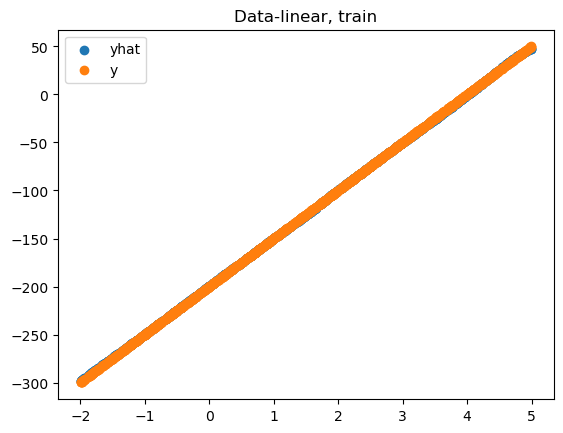

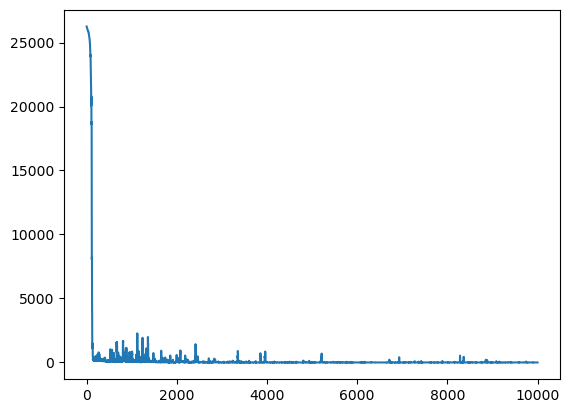

In [62]:
df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))

nn3.reset_weights_and_biases()
train_NN_visualize(nn3, x_train, x_test, y_train, y_test, epochs=10000, LR=0.0001)

MSE (train): 2.4597
MSE (test): 2.4597


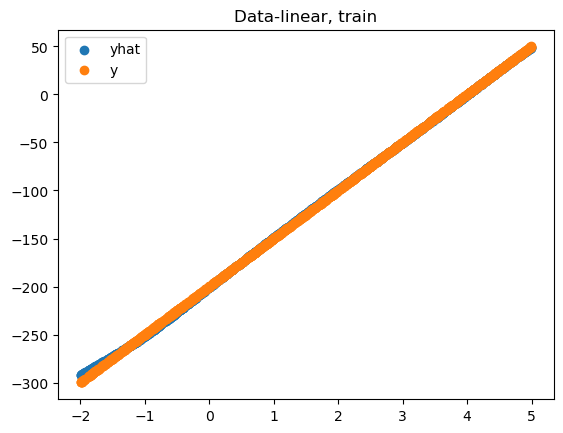

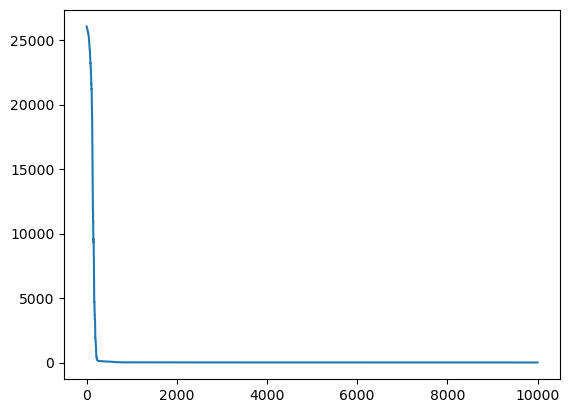

In [64]:
df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))

nn4.reset_weights_and_biases()
train_NN_visualize(nn4, x_train, x_test, y_train, y_test, epochs=10000, LR=0.0001)

MSE (train): 0.00038966
MSE (test): 0.00038966


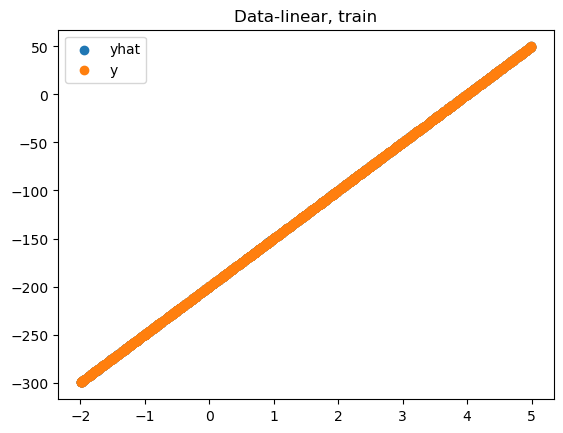

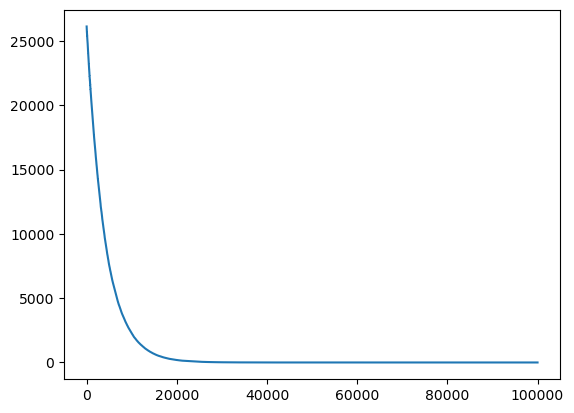

In [66]:
nn5 = NN(input_shape=(0,1))
ol5 = nn5.add_new_random_layer(1, activation=Linear())

df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))

nn4.reset_weights_and_biases()
train_NN_visualize(nn5, x_train, x_test, y_train, y_test, epochs=100000, LR=0.0001)

C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:83: RuntimeWarning: overflow encountered in power
  return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))
C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:26: RuntimeWarning: overflow encountered in square
  return np.sum((yhat - y)**2) / len(yhat)
C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:86: RuntimeWarning: overflow encountered in power
  tanh_part = np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3))
C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:131: RuntimeWarning: overflow encountered in matmul
  intensities = inputs @ self.weights
C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:83: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))
C:\Users\aaf6\AppData\Local\Temp\ipykernel_21440\2403180281.py:87: RuntimeWarning: invalid value encountered 

MSE (train): nan
MSE (test): nan


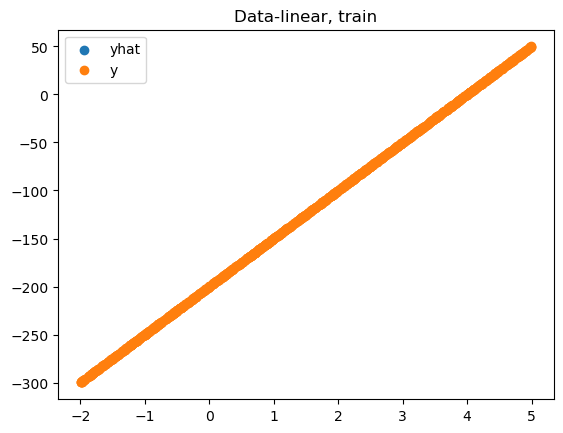

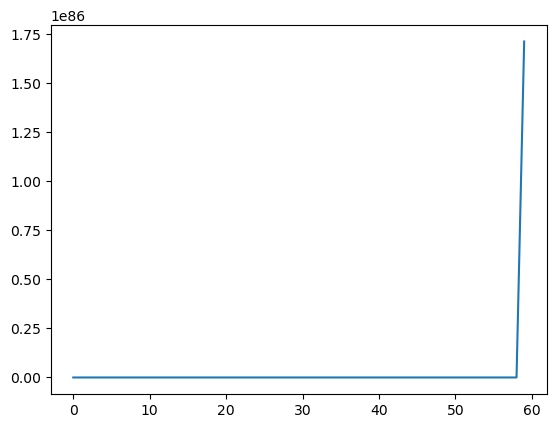

Function 'train_NN_visualize' took 136.23 seconds to complete.


In [73]:
nn6 = NN(input_shape=(0,1))
h16 = nn6.add_new_random_layer(10, GELU())
h16 = nn6.add_new_random_layer(10, GELU())
h16 = nn6.add_new_random_layer(10, GELU())
h16 = nn6.add_new_random_layer(10, GELU())
ol6 = nn6.add_new_random_layer(1, activation=Linear())

df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.linear.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))

nn6.reset_weights_and_biases()
train_NN_visualize(nn6, x_train, x_test, y_train, y_test, epochs=100000, LR=0.0001)

In [82]:
import time

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' took {end_time - start_time:.2f} seconds to complete.")
        return result
    return wrapper

def make_scaler(x_vec):
    x_max = np.max(x_vec)
    x_min = np.min(x_vec)
    def scaler(x):
        nonlocal x_max, x_min
        return (x - x_min) / (x_max - x_min)
    def rev_scaler(x):
        nonlocal x_max, x_min
        return x * (x_max - x_min) + x_min
    return scaler, rev_scaler

@timing_decorator
def train_NN_visualize(nn, x_train, x_test, y_train, y_test, epochs=10000, LR=0.001 , loss=MSE()):
    np.random.seed(1337)
    errors = []
    errors_test = []
    for _ in range(epochs):
        nn.stochastic_descent(x_train, y_train, rate=LR, loss=loss)
        errors.append(MSE()(nn.apply(x_train), y_train))
        errors_test.append(MSE()(nn.apply(x_test), y_test))

    print(f"MSE (train): {loss(nn.apply(x_train), y_train):.5}")
    print(f"MSE (test): {loss(nn.apply(x_test), y_test):.5}")

    plt.scatter(x_train, nn.apply(x))
    plt.scatter(x_train,y_train)
    plt.title("Data-linear, train")
    plt.legend(["yhat", "y"])
    plt.show()

    plt.plot(range(len(errors)), errors)
    #plt.plot(range(len(errors_test)), errors_test)
    plt.show()
    return nn


In [83]:
nn = NN(input_shape=(0,1))
h1 = nn.add_new_random_layer(10, GELU())
h2 = nn.add_new_random_layer(10, GELU())
h3 = nn.add_new_random_layer(10, GELU())
h4 = nn.add_new_random_layer(10, GELU())
ol = nn.add_new_random_layer(1, activation=Linear())

df_test = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.multimodal.train.1000.csv")
x_test = np.array(df_test.iloc[:,0]).reshape((len(df_test),1))
y_test = np.array(df_test.iloc[:,1]).reshape((len(df_test),1))

df_train = pd.read_csv(r"D:\Pulpit\SN_MINI\data\projekt1-oddanie\regression\data.multimodal.train.1000.csv")
x_train = np.array(df_train.iloc[:,0]).reshape((len(df_train),1))
y_train = np.array(df_train.iloc[:,1]).reshape((len(df_train),1))

mm_sc, mm_rsc = make_scaler(y_train)
ymm_sc = mm_sc(y_train)

nn.reset_weights_and_biases()
#train_NN_visualize(nn, x_train, x_test, y_train, y_test, epochs=100000, LR=0.001)

In [88]:
rate=0.25
batch_size = 10
for i in range(1000000):
    nn.batch_descent(x_train, ymm_sc, rate=0.25, batch_size=batch_size, loss=MSE())
    if i % 1000 == 0:
        mse = loss(mm_rsc(nn.apply(x_train)), y_train)
        print('\r', mse, end='')
        if mse <= 100:
            batch_size = 50
        elif mse <= 1000:
            rate = 0.01
        if mse <= 30.0:
            break
print(i)

 17.5770914207343644000


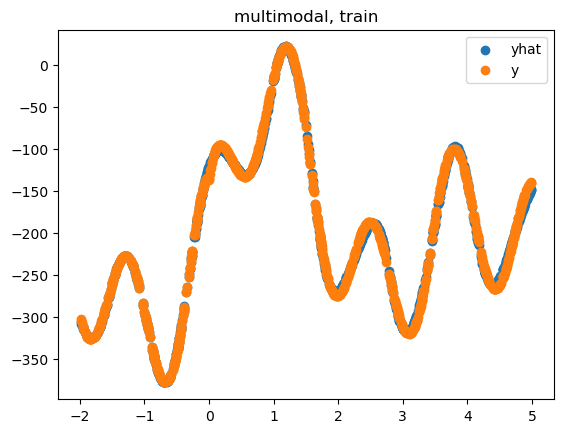

In [89]:
plt.scatter(
    x_train, mm_rsc(nn.apply(x_train))
)
plt.scatter(
    x_train, y_train
)
plt.title("multimodal, train")
plt.legend(["yhat", "y"])
plt.show()

In [117]:
data_circles_train = pd.read_csv("D:\Pulpit\SN_MINI\data\projekt1-oddanie\clasification\data.circles.train.1000.csv")
data_circles_test = pd.read_csv("D:\Pulpit\SN_MINI\data\projekt1-oddanie\clasification\data.circles.test.1000.csv")

x_train = np.array(data_circles_train.iloc[:,0:2]).reshape((len(data_circles_train),2))
x_test = np.array(data_circles_train.iloc[:,0:2]).reshape((len(data_circles_train),2))

y_train = np.array(data_circles_test.iloc[:,2]).reshape((len(data_circles_test),1))
y_test = np.array(data_circles_test.iloc[:,2]).reshape((len(data_circles_test),1))

In [ ]:
nnr4 = nncf.get((2, 32, 32, 2))
nnr4t = Trainer(
    nnr4,
    x_train,
    y_train_ohe,
    x_test=x_test,
    y_test=y_test_ohe,
    dataset_name="XOR",
    evaluator=MultiClassificationEvaluator()
)

In [119]:
y_train_ohe = ohe(y_train, 5)

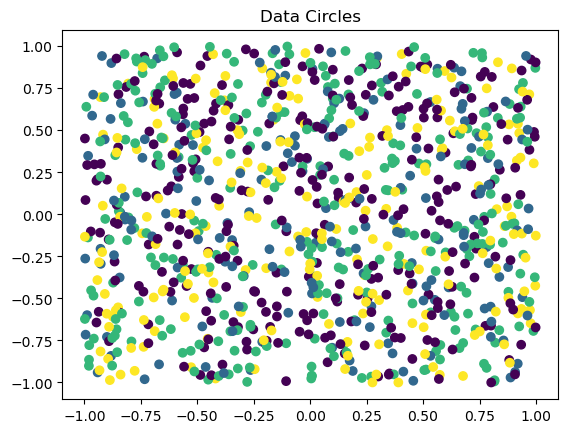

In [122]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.title("Data Circles")
plt.show()

In [216]:
data_XOR_train = pd.read_csv("D:\Pulpit\SN_MINI\data\projekt1-oddanie\clasification\data.XOR.train.1000.csv")
data_XOR_test = pd.read_csv("D:\Pulpit\SN_MINI\data\projekt1-oddanie\clasification\data.XOR.test.1000.csv")

x_train = np.array(data_XOR_train.iloc[:,0:2]).reshape((len(data_XOR_train),2))
x_test = np.array(data_XOR_test.iloc[:,0:2]).reshape((len(data_XOR_test),2))

y_train = np.array(data_XOR_train.iloc[:,2]).reshape((len(data_XOR_train),1))
y_test = np.array(data_XOR_test.iloc[:,2]).reshape((len(data_XOR_test),1))

y_train_ohe = ohe(y_train-1,2)
y_test_ohe = ohe(y_test-1,2)

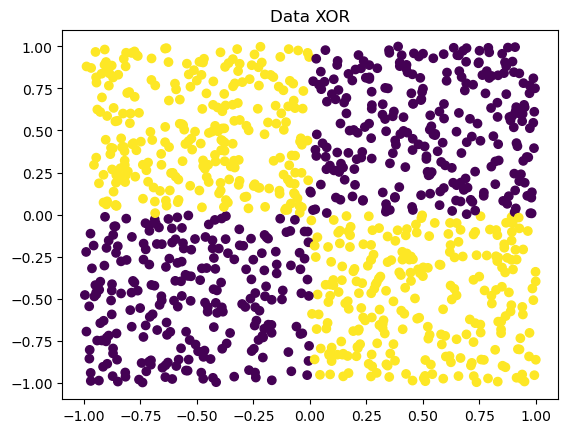

In [217]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train-1)
plt.title("Data XOR")
plt.show()

In [218]:
nncf = NNFactory(SigmoidSoftmaxActivationStrategy(), LayerFactory(UniformInitializer()), CCESoftMaxLoss())

In [226]:
nnr3 = nncf.get((2, 32, 32, 2))
nnr3t = Trainer(
    nnr3,
    x_train,
    y_train_ohe,
    x_test=x_test,
    y_test=y_test_ohe,
    dataset_name="XOR",
    tracker= ProgressTracker(5),
    evaluator=MultiClassificationEvaluator()
)

In [227]:
nnr3t.momentum_method_batch(1_000_00, batch_size=32)
nnr3t.train_gradient(1_000)

NotImplementedError: 

XOR, train F-measure (macro): 0.8798919027124412


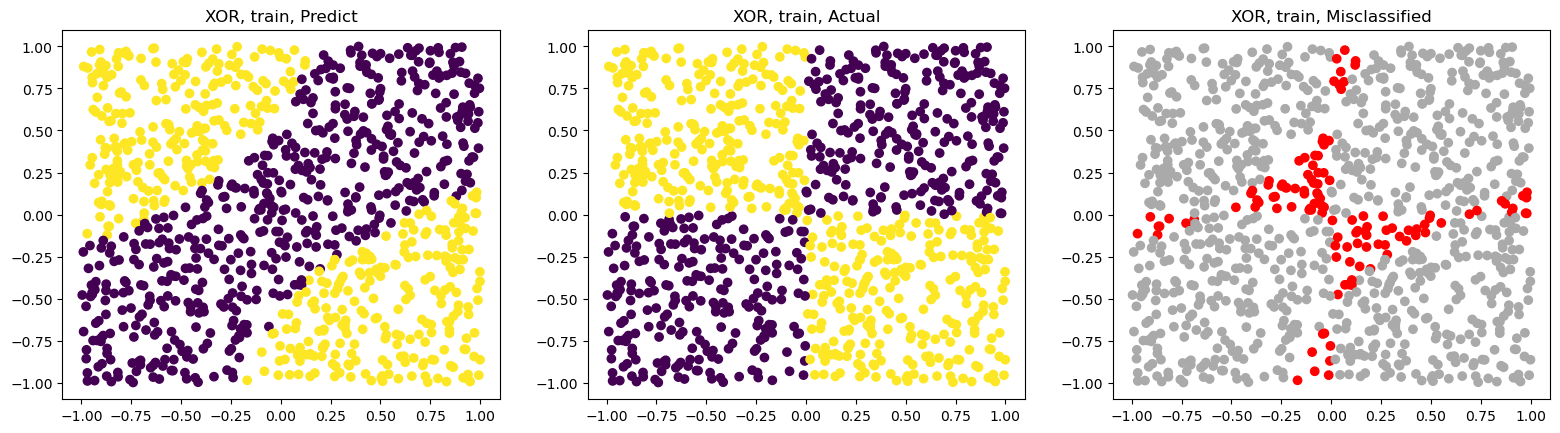

In [222]:
nnr3t.plot_results()
plt.show()